# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm  # tqdm_notebook устарел

# Установите стиль seaborn
sns.set_style("darkgrid")
sns.set_palette("husl")  # Опционально

%matplotlib inline
import matplotlib.pyplot as plt

# Настройки matplotlib (уже не нужен style.use)
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%pip install scikit-learn
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

Defaulting to user installation because normal site-packages is not writeable
  Using cached scipy-1.16.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.0 MB 5.6 MB/s eta 0:00:02
   -------------- ------------------------- 2.9/8.0 MB 7.6 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.0 MB 8.6 MB/s eta 0:00:01
   ------------------------------ --------- 6.0/8.0 MB 7.7 MB/s eta 0:00:01
   ---------------------------------------  7.9/8.0 MB 8.0 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 7.4 MB/s  0:00:01
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached scipy-1.16.3-cp312-cp312-win_amd64.whl (38.6 MB)
Using cached t

In [12]:
X_train = np.loadtxt("datasets/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("datasets/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("datasets/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("datasets/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt").astype(int)

In [13]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [14]:
# Ваш код здесь
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

Определим число уникальных значений меток целевого класса.

In [15]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [16]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [ ]:
# Ваш код здесь
scaler = StandardScaler()
scaler.fit(X)  # Вычисляем среднее и стандартное отклонение
X_scaled = scaler.transform(X)

Средние значения (до масштабирования): [ 0.27434726 -0.01774349 -0.10892503 -0.60778382 -0.51019138]...
Стандартные отклонения (до масштабирования): [0.06762451 0.03712636 0.05303051 0.43867253 0.50021548]...

Проверка размерности:
X_scaled shape: (10299, 561)
Ожидаемая размерность: (10299, 561)


Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [ ]:
# Ваш код здесь
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)


**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- 65
- 66
- 193

In [ ]:
# Ваш код здесь
n_components = pca.n_components_
print(n_components) #ответ 65

65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51
- 56
- 61

In [ ]:
# Ваш код здесь
variance_first_component = pca.explained_variance_ratio_[0]
variance_percent = round(variance_first_component * 100)
print(variance_percent) # ответ 51

51


Визуализируйте данные в проекции на первые две главные компоненты.

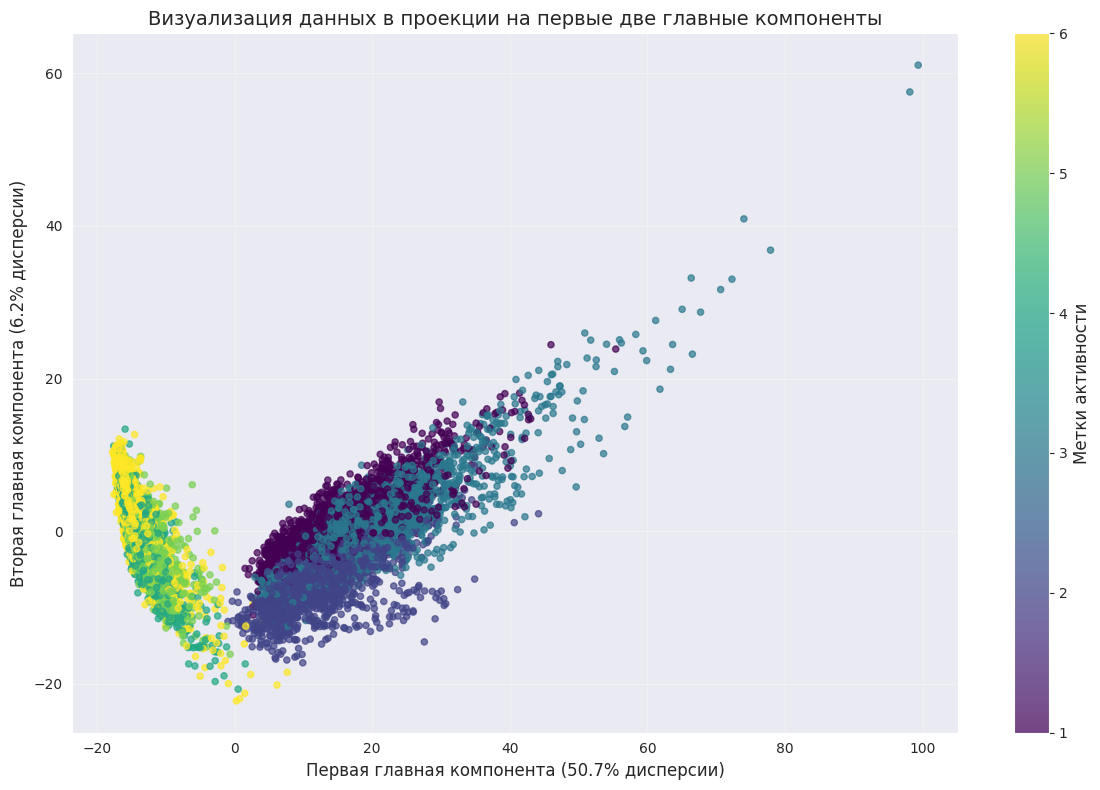

In [23]:
# Ваш код здесь
plt.figure(figsize=(12, 8))

# Создаем scatter plot, используя первые две компоненты PCA
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=y, s=20, cmap='viridis', alpha=0.7)

# Добавляем colorbar для интерпретации цветов
cbar = plt.colorbar(scatter)
cbar.set_label('Метки активности', fontsize=12)

# Настраиваем заголовок и подписи осей
plt.title('Визуализация данных в проекции на первые две главные компоненты', fontsize=14)
plt.xlabel(f'Первая главная компонента ({pca.explained_variance_ratio_[0]*100:.1f}% дисперсии)', fontsize=12)
plt.ylabel(f'Вторая главная компонента ({pca.explained_variance_ratio_[1]*100:.1f}% дисперсии)', fontsize=12)

# Добавляем сетку для лучшей читаемости
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [27]:
# Ваш код здесь

from sklearn.cluster import KMeans

# Определяем количество кластеров (равное числу уникальных меток)
n_clusters = len(np.unique(y))

# Создаем и обучаем модель KMeans
kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=RANDOM_STATE)
kmeans_labels = kmeans.fit_predict(X_pca)

class MyKMeans:
    def __init__(self, n_clusters=8, n_init=10, max_iter=300, random_state=None, tol=1e-4):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol
        self.labels_ = None
        self.cluster_centers_ = None
        self.inertia_ = None
        self.n_iter_ = 0
        
    def fit(self, X):
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        n_samples = X.shape[0]
        best_inertia = float('inf')
        
        # Многократная инициализация
        for init in range(self.n_init):
            # Случайная инициализация центроидов
            random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
            centroids = X[random_indices].copy()
            
            for iteration in range(self.max_iter):
                # Вычисление расстояний от каждой точки до каждого центроида
                distances = np.zeros((n_samples, self.n_clusters))
                for k in range(self.n_clusters):
                    distances[:, k] = np.linalg.norm(X - centroids[k], axis=1)**2
                
                # Назначение меток (ближайший центроид)
                labels = np.argmin(distances, axis=1)
                
                # Вычисление новых центроидов
                new_centroids = np.zeros_like(centroids)
                for k in range(self.n_clusters):
                    cluster_points = X[labels == k]
                    if len(cluster_points) > 0:
                        new_centroids[k] = cluster_points.mean(axis=0)
                    else:
                        # Если кластер пустой, переинициализируем случайной точкой
                        new_centroids[k] = X[np.random.randint(0, n_samples)]
                
                # Проверка сходимости
                centroid_shift = np.linalg.norm(new_centroids - centroids)
                if centroid_shift < self.tol:
                    break
                    
                centroids = new_centroids
            
            # Вычисление инерции
            inertia = 0
            for k in range(self.n_clusters):
                cluster_points = X[labels == k]
                if len(cluster_points) > 0:
                    inertia += np.sum((cluster_points - centroids[k])**2)
            
            # Сохранение лучшего результата
            if inertia < best_inertia:
                best_inertia = inertia
                best_labels = labels.copy()
                best_centroids = centroids.copy()
                best_iterations = iteration + 1
        
        # Сохранение результатов
        self.labels_ = best_labels
        self.cluster_centers_ = best_centroids
        self.inertia_ = best_inertia
        self.n_iter_ = best_iterations
        
        return self
    
    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

# Создание и обучение собственной реализации KMeans
my_kmeans = MyKMeans(n_clusters=n_clusters, n_init=100, random_state=RANDOM_STATE)
my_kmeans_labels = my_kmeans.fit_predict(X_pca)

print("\nСобственная реализация KMeans:")
print(f"Количество кластеров: {n_clusters}")
print(f"Количество итераций: {my_kmeans.n_iter_}")
print(f"Инерция: {my_kmeans.inertia_:.2f}")


Собственная реализация KMeans:
Количество кластеров: 6
Количество итераций: 21
Инерция: 2003454.20


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

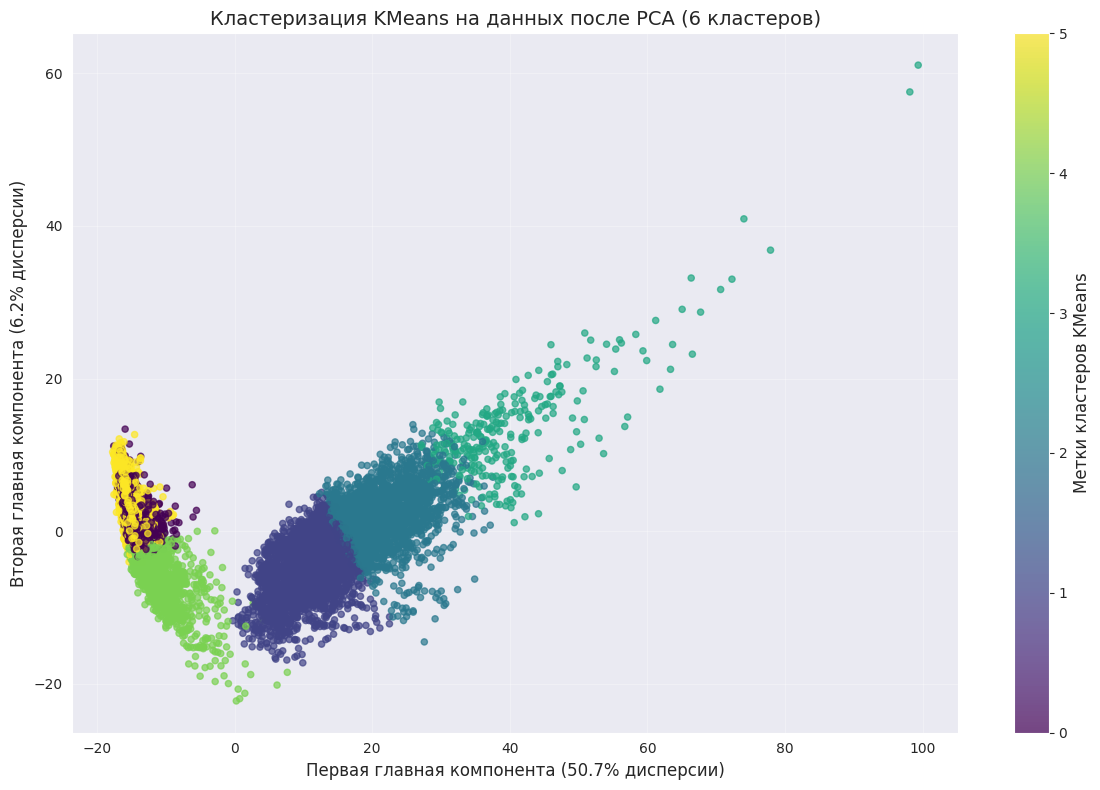

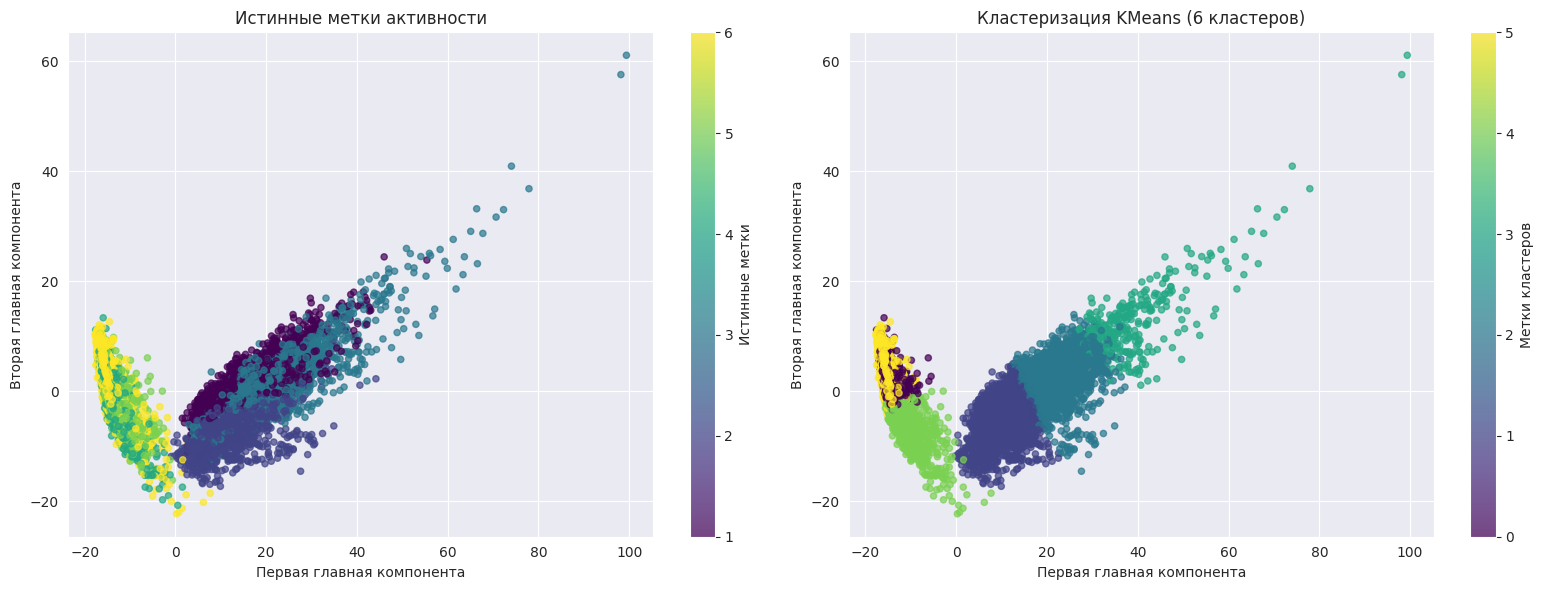

Анализ кластеризации KMeans:
----------------------------------------
Количество кластеров: 6
Инерция: 2003454.90
Уникальные метки кластеров: [0 1 2 3 4 5]

Количество точек в каждом кластере:
Кластер 0: 2631 точек
Кластер 1: 2470 точек
Кластер 2: 1927 точек
Кластер 3: 279 точек
Кластер 4: 1343 точек
Кластер 5: 1649 точек

Сравнение распределения истинных меток по кластерам KMeans:
(по строкам - истинные метки, по столбцам - кластеры KMeans)
col_0     0     1    2    3    4     5
row_0                                 
1         0   903  741   78    0     0
2         0  1241  296    5    2     0
3         0   320  890  196    0     0
4      1235     1    0    0  450    91
5      1344     0    0    0  562     0
6        52     5    0    0  329  1558


In [29]:
# Визуализация данных с метками кластеризации KMeans
plt.figure(figsize=(12, 8))

# Визуализируем данные в проекции на первые две главные компоненты
# с раскраской по меткам кластеризации KMeans
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=kmeans_labels, s=20, cmap='viridis', alpha=0.7)

# Добавляем цветовую шкалу
cbar = plt.colorbar(scatter)
cbar.set_label('Метки кластеров KMeans', fontsize=12)

# Настраиваем заголовок и подписи осей
plt.title('Кластеризация KMeans на данных после PCA (6 кластеров)', fontsize=14)
plt.xlabel(f'Первая главная компонента ({pca.explained_variance_ratio_[0]*100:.1f}% дисперсии)', fontsize=12)
plt.ylabel(f'Вторая главная компонента ({pca.explained_variance_ratio_[1]*100:.1f}% дисперсии)', fontsize=12)

# Добавляем сетку
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Для сравнения можно создать два графика рядом: истинные метки и метки кластеризации
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Истинные метки
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis', alpha=0.7)
axes[0].set_title('Истинные метки активности', fontsize=12)
axes[0].set_xlabel('Первая главная компонента')
axes[0].set_ylabel('Вторая главная компонента')
plt.colorbar(scatter1, ax=axes[0], label='Истинные метки')

# Метки кластеризации KMeans
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, s=20, cmap='viridis', alpha=0.7)
axes[1].set_title('Кластеризация KMeans (6 кластеров)', fontsize=12)
axes[1].set_xlabel('Первая главная компонента')
axes[1].set_ylabel('Вторая главная компонента')
plt.colorbar(scatter2, ax=axes[1], label='Метки кластеров')

plt.tight_layout()
plt.show()

# Анализ результатов
print("Анализ кластеризации KMeans:")
print("-" * 40)
print(f"Количество кластеров: {n_clusters}")
print(f"Инерция: {kmeans.inertia_:.2f}")
print(f"Уникальные метки кластеров: {np.unique(kmeans_labels)}")

# Подсчет количества точек в каждом кластере
cluster_counts = np.bincount(kmeans_labels)
print("\nКоличество точек в каждом кластере:")
for cluster_id, count in enumerate(cluster_counts):
    print(f"Кластер {cluster_id}: {count} точек")

# Сравнение с истинными метками
print("\nСравнение распределения истинных меток по кластерам KMeans:")
print("(по строкам - истинные метки, по столбцам - кластеры KMeans)")
cross_tab = pd.crosstab(y, kmeans_labels)
print(cross_tab)

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [ ]:
# Создаем таблицу сопряженности между истинными метками и метками кластеров
tab = pd.crosstab(y, kmeans_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [ ]:

from tqdm.notebook import tqdm
from sklearn.cluster import KMeans

# Убедимся, что n_classes определено (если нет, определим)
if 'n_classes' not in locals() and 'n_clusters' in locals():
    n_classes = n_clusters
elif 'n_classes' not in locals():
    n_classes = len(np.unique(y))

# Вычисляем инерцию для разного количества кластеров
inertia = []

for k in tqdm(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Визуализируем метод локтя
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_classes + 1), inertia, 'bo-', linewidth=2, markersize=8)
plt.title('Метод локтя для выбора оптимального количества кластеров', fontsize=14)
plt.xlabel('Количество кластеров', fontsize=12)
plt.ylabel('Инерция', fontsize=12)
plt.xticks(range(1, n_classes + 1))
plt.grid(True, alpha=0.3)
plt.show()

# Выводим значения инерции для анализа
print("Значения инерции для k от 1 до", n_classes)
for k, inert in enumerate(inertia, start=1):
    print(f"k = {k}: {inert:.2f}")

# Рассчитываем и выводим изменение инерции (разности)
print("\nИзменение инерции (разности):")
for i in range(1, len(inertia)):
    diff = inertia[i-1] - inertia[i]
    print(f"k от {i} к {i+1}: {diff:.2f}")

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
2

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [42]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [43]:
from sklearn.metrics import adjusted_rand_score

# Кластеризация AgglomerativeClustering
ag = AgglomerativeClustering(n_clusters=n_classes, linkage='ward')
ag_labels = ag.fit_predict(X_pca)

# Кластеризация KMeans (обучаем заново с теми же параметрами)
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans_labels_new = kmeans.fit_predict(X_pca)

# Вычисляем Adjusted Rand Index
ari_ag = adjusted_rand_score(y, ag_labels)
ari_kmeans = adjusted_rand_score(y, kmeans_labels_new)

print("Adjusted Rand Index (ARI):")
print(f"AgglomerativeClustering (ward linkage): {ari_ag:.4f}")
print(f"KMeans: {ari_kmeans:.4f}")

# Сравниваем с результатом из предыдущего задания (если сохранили)
if 'kmeans_labels' in locals():
    ari_kmeans_old = adjusted_rand_score(y, kmeans_labels)
    print(f"KMeans (из предыдущего задания): {ari_kmeans_old:.4f}")

# Определяем, какой метод лучше
if ari_ag > ari_kmeans:
    print("\nAgglomerativeClustering показывает лучший результат")
elif ari_kmeans > ari_ag:
    print("\nKMeans показывает лучший результат")
else:
    print("\nМетоды показывают одинаковый результат")

Adjusted Rand Index (ARI):
AgglomerativeClustering (ward linkage): 0.4936
KMeans: 0.4198
KMeans (из предыдущего задания): 0.4198

AgglomerativeClustering показывает лучший результат


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

ВСЕ УТВЕРЖДЕНИЯ ВЕРНЫЕ

- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

Размерность X_train_scaled: (7352, 561)
Размерность X_test_scaled: (2947, 561)
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Результаты GridSearchCV:
Лучший параметр C: {'C': 0.1}
Лучшая точность при кросс-валидации: 0.9380

Точность на тестовой выборке: 0.9620

Отчет по классификации:
                    precision    recall  f1-score   support

           Walking       0.97      1.00      0.98       496
  Walking Upstairs       0.98      0.97      0.98       471
Walking Downstairs       1.00      0.98      0.99       420
           Sitting       0.96      0.87      0.91       491
          Standing       0.88      0.97      0.92       532
            Laying       1.00      0.98      0.99       537

          accuracy                           0.96      2947
         macro avg       0.97      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



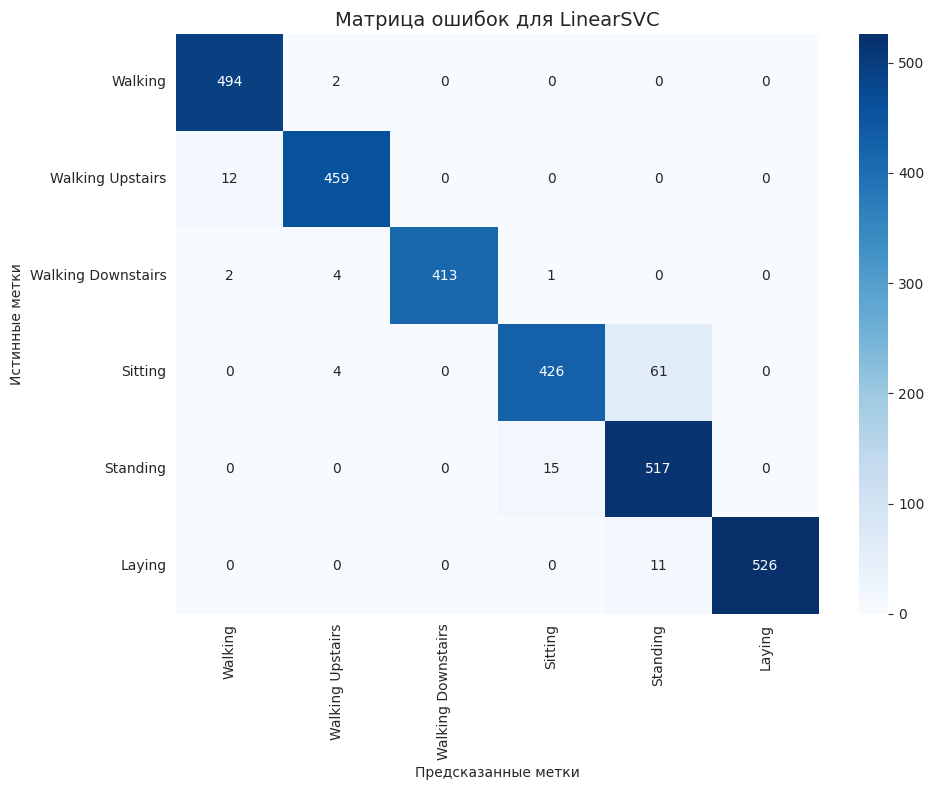


Анализ по классам:
Walking: точность = 0.996, поддержка = 496
Walking Upstairs: точность = 0.975, поддержка = 471
Walking Downstairs: точность = 0.983, поддержка = 420
Sitting: точность = 0.868, поддержка = 491
Standing: точность = 0.972, поддержка = 532
Laying: точность = 0.980, поддержка = 537


In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# 1. Масштабирование данных
scaler_svc = StandardScaler()
X_train_scaled = scaler_svc.fit_transform(X_train)
X_test_scaled = scaler_svc.transform(X_test)

print(f"Размерность X_train_scaled: {X_train_scaled.shape}")
print(f"Размерность X_test_scaled: {X_test_scaled.shape}")

# 2. Настройка гиперпараметра C с помощью GridSearchCV
# Создаем сетку параметров для поиска
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Создаем модель LinearSVC
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)

# Создаем GridSearchCV
grid_search = GridSearchCV(
    svc, 
    param_grid, 
    cv=3, 
    scoring='accuracy',
    n_jobs=-1,  # используем все доступные ядра
    verbose=1
)

# Обучаем GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# 3. Выводим результаты
print("\nРезультаты GridSearchCV:")
print(f"Лучший параметр C: {grid_search.best_params_}")
print(f"Лучшая точность при кросс-валидации: {grid_search.best_score_:.4f}")

# 4. Оцениваем на тестовой выборке
best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nТочность на тестовой выборке: {test_accuracy:.4f}")

# 5. Детальный отчет по классификации
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred, 
                           target_names=['Walking', 'Walking Upstairs', 'Walking Downstairs',
                                         'Sitting', 'Standing', 'Laying']))

# 6. Матрица ошибок
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Walking', 'Walking Upstairs', 'Walking Downstairs',
                         'Sitting', 'Standing', 'Laying'],
            yticklabels=['Walking', 'Walking Upstairs', 'Walking Downstairs',
                         'Sitting', 'Standing', 'Laying'])
plt.title('Матрица ошибок для LinearSVC', fontsize=14)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.tight_layout()
plt.show()

# 7. Анализ результатов по каждому классу
print("\nАнализ по классам:")
class_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs',
               'Sitting', 'Standing', 'Laying']

for i, class_name in enumerate(class_names, 1):
    class_accuracy = cm[i-1, i-1] / cm[i-1, :].sum()
    print(f"{class_name}: точность = {class_accuracy:.3f}, поддержка = {cm[i-1, :].sum()}")

In [45]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [46]:
# Лучшая модель после GridSearchCV
best_svc = grid_search.best_estimator_

print("Информация о лучшей модели LinearSVC:")
print(f"Параметр C: {best_svc.C}")
print(f"Количество итераций: {best_svc.n_iter_}")
print(f"Классы: {best_svc.classes_}")

# Дополнительно: посмотрим на веса признаков (только первые 5 признаков для примера)
print(f"\nВеса для каждого класса (первые 5 признаков):")
for i, class_label in enumerate(best_svc.classes_):
    print(f"Класс {class_label} ({class_names[class_label-1]}): {best_svc.coef_[i][:5]}...")

print(f"\nСвободные члены (intercept): {best_svc.intercept_}")

# Сохраним модель для возможного дальнейшего использования
import joblib
joblib.dump(best_svc, 'best_svc_model.pkl')
joblib.dump(scaler_svc, 'scaler_svc.pkl')
print("\nМодель и scaler сохранены в файлы 'best_svc_model.pkl' и 'scaler_svc.pkl'")

Информация о лучшей модели LinearSVC:
Параметр C: 0.1
Количество итераций: 87
Классы: [1 2 3 4 5 6]

Веса для каждого класса (первые 5 признаков):
Класс 1 (Walking): [ 0.01321628 -0.01515694  0.04170961 -0.08481983  0.07213534]...
Класс 2 (Walking Upstairs): [-0.06195439 -0.03144539 -0.06719246  0.21483607 -0.00394324]...
Класс 3 (Walking Downstairs): [ 0.09987024  0.04109987  0.05527921  0.03499955 -0.04601813]...
Класс 4 (Sitting): [ 0.02264879 -0.06842936 -0.10469166 -0.10425728  0.00157803]...
Класс 5 (Standing): [ 0.01871285  0.04990642  0.03573392 -0.10284407 -0.09453259]...
Класс 6 (Laying): [-0.02399477 -0.01588498 -0.00488903  0.0014817   0.00136591]...

Свободные члены (intercept): [-1.4293841  -1.80593173 -1.32968801 -2.01445328 -2.26921369 -0.71396713]

Модель и scaler сохранены в файлы 'best_svc_model.pkl' и 'scaler_svc.pkl'


In [ ]:
# Ваш код здесь

**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>
- 0.1

In [47]:
y_predicted = best_svc.predict(X_test_scaled)

In [48]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – сидение, по полноте – стояние

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**ОТВЕТ**
- 2%


Исходная размерность: 561
Размерность после PCA: 63
Объясненная дисперсия: 90.05%
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Лучший параметр C с PCA: {'C': 0.1}
Лучшая точность на кросс-валидации (с PCA): 0.8984
Точность на тестовой выборке (с PCA): 0.9192

Сравнение с моделью без PCA:
Лучшая точность на кросс-валидации (без PCA): 0.9380
Точность на тестовой выборке (без PCA): 0.9620

Разница в точности на кросс-валидации (без PCA - с PCA): 3.96%
Разница в точности на тестовой выборке (без PCA - с PCA): 4.28%


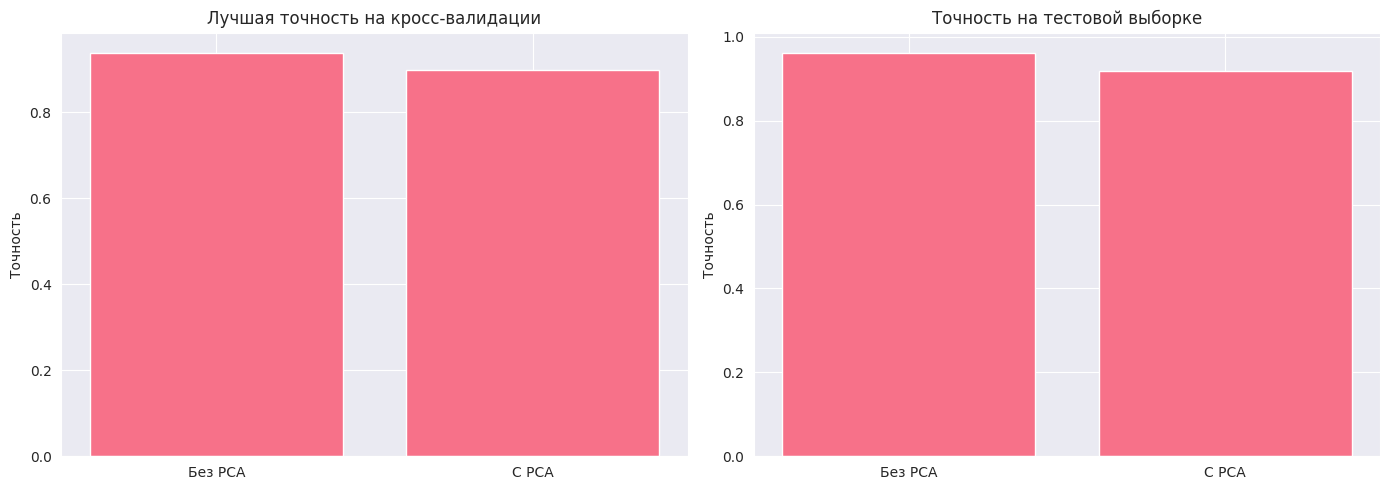

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Время обучения без PCA: 64.68 сек
Время обучения с PCA: 3.65 сек
Ускорение: 17.72 раз


In [49]:
# 1. Масштабирование данных (используем StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Применение PCA (объяснить 90% дисперсии)
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Исходная размерность: {X_train_scaled.shape[1]}")
print(f"Размерность после PCA: {X_train_pca.shape[1]}")
print(f"Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.2%}")

# 3. Настройка гиперпараметра C для LinearSVC с использованием PCA-признаков
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search_pca = GridSearchCV(
    svc, 
    param_grid, 
    cv=3, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_pca.fit(X_train_pca, y_train)

# 4. Лучшая модель и её оценка
best_svc_pca = grid_search_pca.best_estimator_
print(f"\nЛучший параметр C с PCA: {grid_search_pca.best_params_}")
print(f"Лучшая точность на кросс-валидации (с PCA): {grid_search_pca.best_score_:.4f}")

# 5. Оценка на тестовой выборке
y_pred_pca = best_svc_pca.predict(X_test_pca)
test_accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Точность на тестовой выборке (с PCA): {test_accuracy_pca:.4f}")

# 6. Сравнение с результатом без PCA (из вопроса 7)
# Предположим, что в предыдущем вопросе мы уже обучили модель без PCA и сохранили результат
# Если переменная grid_search (без PCA) уже существует, то:
print(f"\nСравнение с моделью без PCA:")
print(f"Лучшая точность на кросс-валидации (без PCA): {grid_search.best_score_:.4f}")
print(f"Точность на тестовой выборке (без PCA): {test_accuracy:.4f}")

# 7. Вычисление разницы в качестве
difference_cv = (grid_search.best_score_ - grid_search_pca.best_score_) * 100
difference_test = (test_accuracy - test_accuracy_pca) * 100

print(f"\nРазница в точности на кросс-валидации (без PCA - с PCA): {difference_cv:.2f}%")
print(f"Разница в точности на тестовой выборке (без PCA - с PCA): {difference_test:.2f}%")

# 8. Визуализация результатов
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Точность на кросс-валидации
axes[0].bar(['Без PCA', 'С PCA'], [grid_search.best_score_, grid_search_pca.best_score_])
axes[0].set_ylabel('Точность')
axes[0].set_title('Лучшая точность на кросс-валидации')

# Точность на тестовой выборке
axes[1].bar(['Без PCA', 'С PCA'], [test_accuracy, test_accuracy_pca])
axes[1].set_ylabel('Точность')
axes[1].set_title('Точность на тестовой выборке')

plt.tight_layout()
plt.show()

# 9. Анализ скорости
import time

# Замер времени обучения без PCA (если еще не замеряли)
if 'time_without_pca' not in locals():
    start = time.time()
    grid_search.fit(X_train_scaled, y_train)
    time_without_pca = time.time() - start

# Замер времени обучения с PCA
start = time.time()
grid_search_pca.fit(X_train_pca, y_train)
time_with_pca = time.time() - start

print(f"\nВремя обучения без PCA: {time_without_pca:.2f} сек")
print(f"Время обучения с PCA: {time_with_pca:.2f} сек")
print(f"Ускорение: {time_without_pca/time_with_pca:.2f} раз")

**Вопрос 10:** (1 балл)

Выберите все верные утверждения:
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

Применение t-SNE для визуализации...
Размерность после t-SNE: (10299, 2)

Подбор параметров для DBSCAN...

Применение DBSCAN с подобранными параметрами...
Количество найденных кластеров: 68
Количество шумовых точек: 331
Доля шумовых точек: 3.21%

Сравнение с KMeans на t-SNE данных...


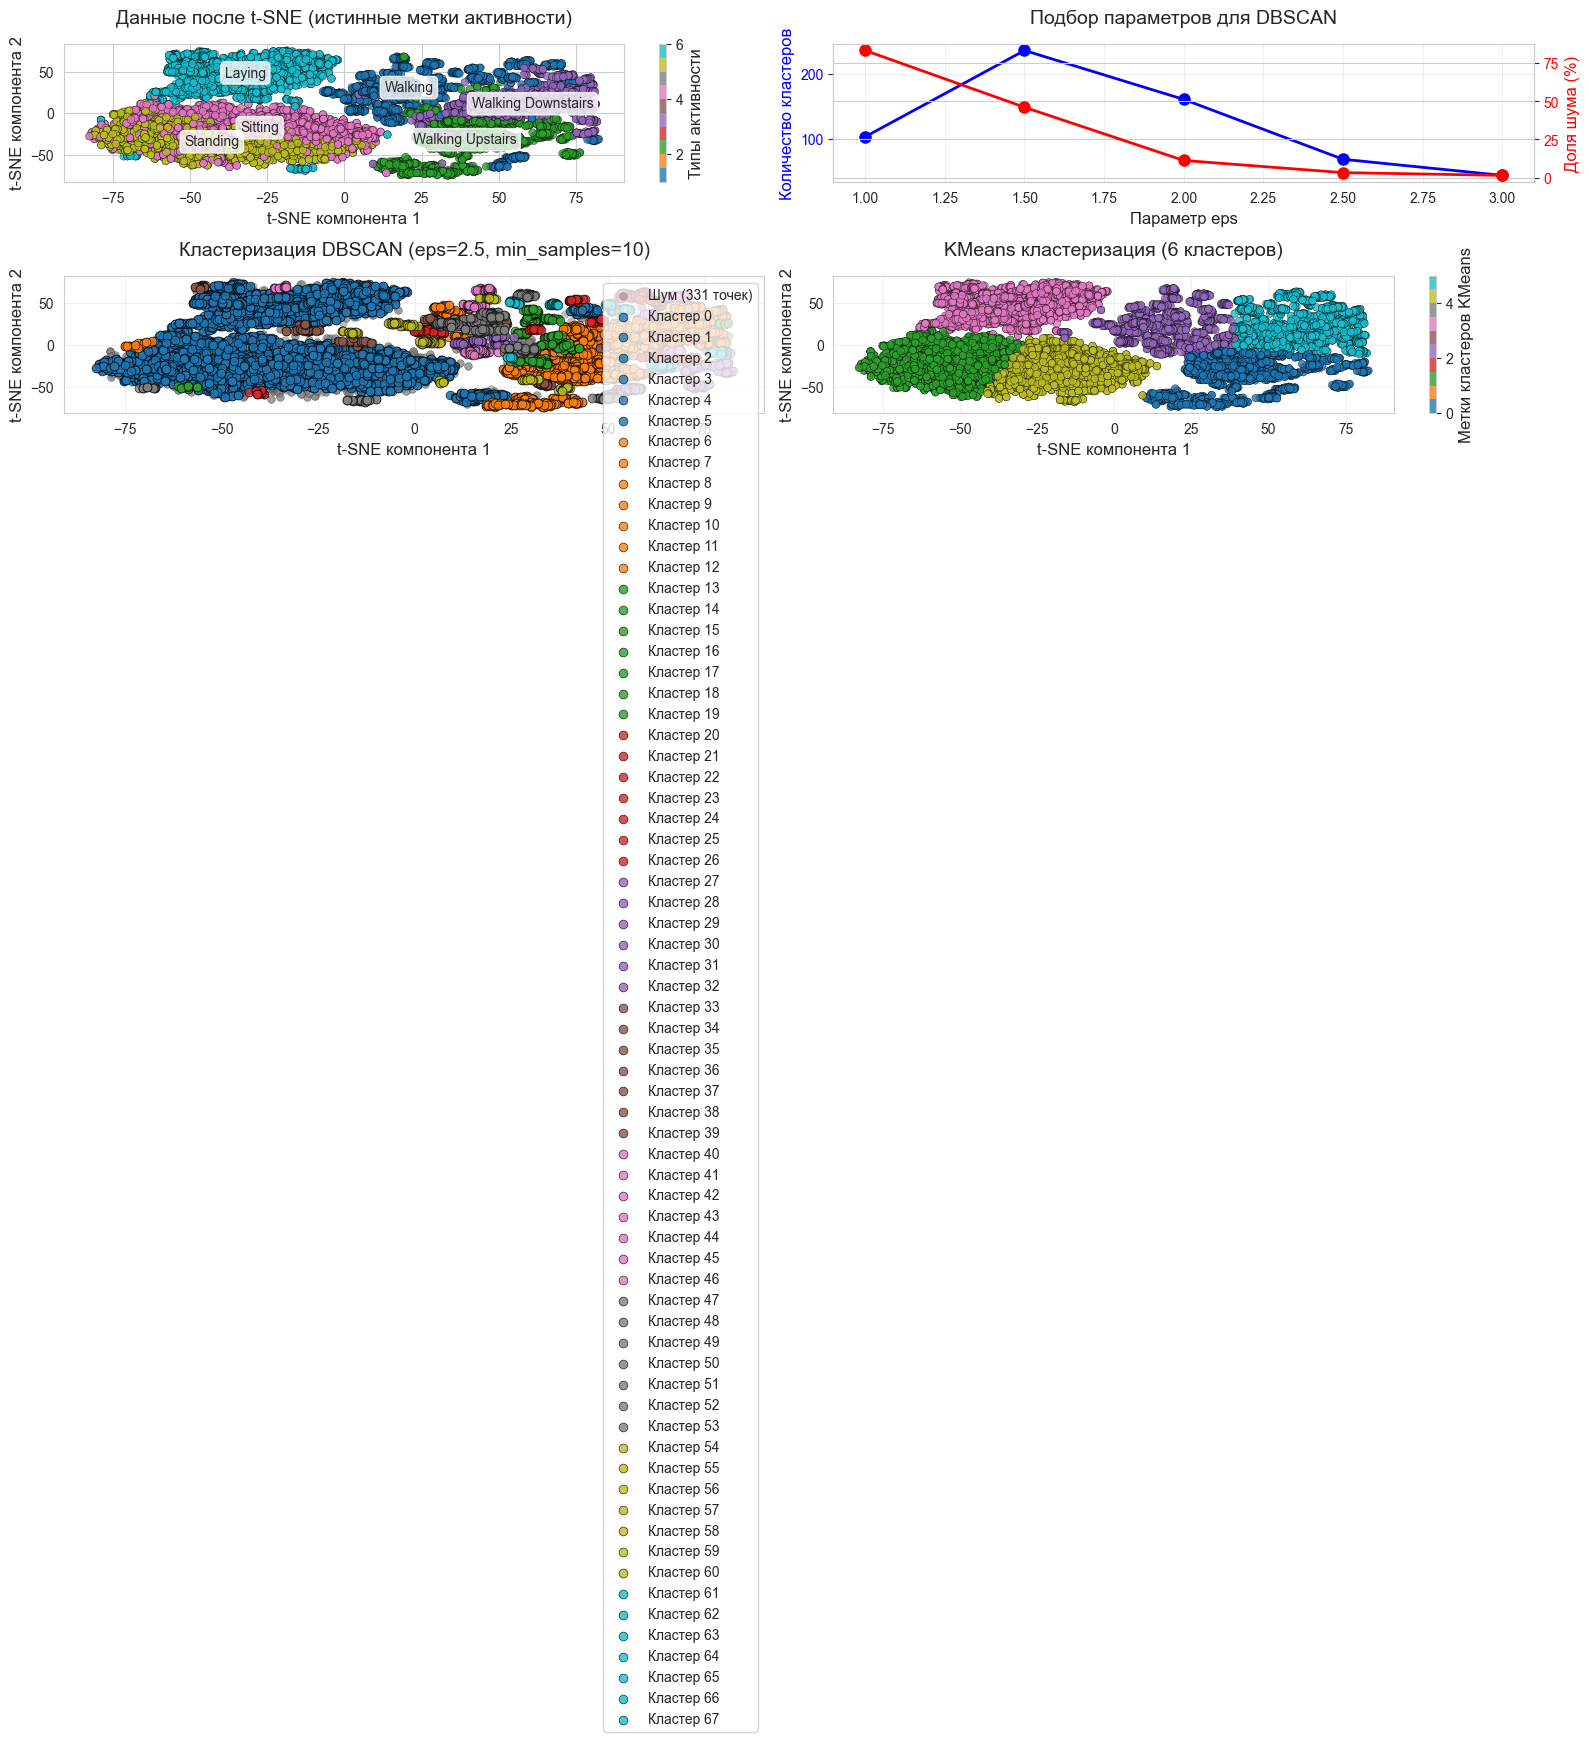

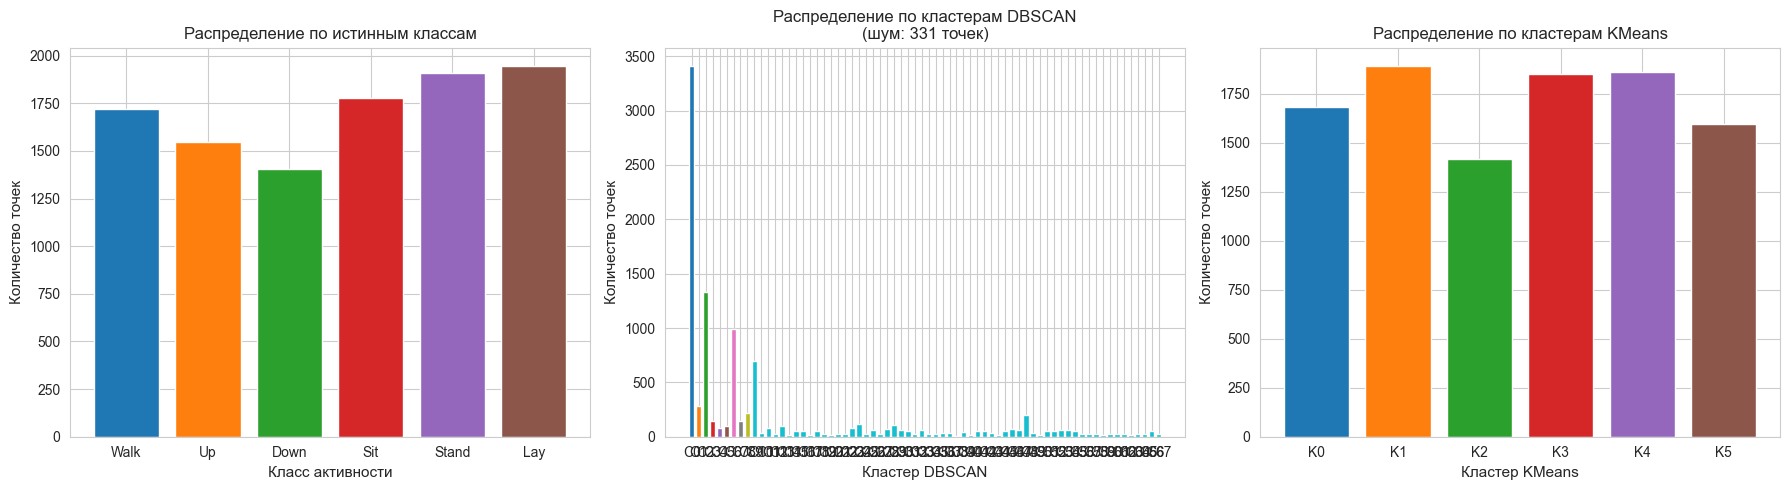


ОЦЕНКА КАЧЕСТВА КЛАСТЕРИЗАЦИИ

DBSCAN (без учета 331 шумовых точек):
  Adjusted Rand Index: 0.4861
  Normalized Mutual Information: 0.6348

KMeans (все точки):
  Adjusted Rand Index: 0.5923
  Normalized Mutual Information: 0.6826

СООТВЕТСТВИЕ КЛАСТЕРОВ DBSCAN ИСТИННЫМ КЛАССАМ

Кластер 0 (3408 точек):
  Основной класс: Standing (1778 точек, 52.2%)
  Также содержит: Sitting (1594, 46.8%)

Кластер 1 (283 точек):
  Основной класс: Laying (283 точек, 100.0%)

Кластер 2 (1333 точек):
  Основной класс: Laying (1327 точек, 99.5%)

Кластер 3 (149 точек):
  Основной класс: Walking Upstairs (146 точек, 98.0%)

Кластер 4 (77 точек):
  Основной класс: Laying (77 точек, 100.0%)

Кластер 5 (95 точек):
  Основной класс: Walking (95 точек, 100.0%)

Кластер 6 (994 точек):
  Основной класс: Walking Downstairs (915 точек, 92.1%)

Кластер 7 (145 точек):
  Основной класс: Walking Downstairs (121 точек, 83.4%)
  Также содержит: Walking (24, 16.6%)

Кластер 8 (221 точек):
  Основной класс: Walking Upstairs 

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import seaborn as sns

# Устанавливаем стиль графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# 1. Применяем t-SNE для понижения размерности до 2D
print("Применение t-SNE для визуализации...")
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, max_iter=1000, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)
print(f"Размерность после t-SNE: {X_tsne.shape}")

# Создаем фигуру с несколькими графиками
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 2. Визуализация данных после t-SNE с истинными метками
scatter1 = axes[0, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=30, 
                              cmap='tab10', alpha=0.8, edgecolor='k', linewidth=0.3)
axes[0, 0].set_title('Данные после t-SNE (истинные метки активности)', fontsize=14, pad=15)
axes[0, 0].set_xlabel('t-SNE компонента 1', fontsize=12)
axes[0, 0].set_ylabel('t-SNE компонента 2', fontsize=12)
cbar1 = plt.colorbar(scatter1, ax=axes[0, 0])
cbar1.set_label('Типы активности', fontsize=12)

# Добавляем аннотации с названиями активностей (в центрах кластеров)
activity_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs',
                  'Sitting', 'Standing', 'Laying']
for i in range(1, 7):
    mask = y == i
    if np.sum(mask) > 0:
        center_x = np.median(X_tsne[mask, 0])
        center_y = np.median(X_tsne[mask, 1])
        axes[0, 0].text(center_x, center_y, activity_names[i-1], 
                       fontsize=10, ha='center', va='center',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# 3. Подбираем параметры DBSCAN и визуализируем процесс
print("\nПодбор параметров для DBSCAN...")
# Пробуем несколько значений eps
eps_values = [1.0, 1.5, 2.0, 2.5, 3.0]
min_samples = 10

n_clusters_list = []
noise_ratio_list = []

for eps in eps_values:
    dbscan_temp = DBSCAN(eps=eps, min_samples=min_samples)
    labels_temp = dbscan_temp.fit_predict(X_tsne)
    n_clusters = len(set(labels_temp)) - (1 if -1 in labels_temp else 0)
    n_noise = np.sum(labels_temp == -1)
    n_clusters_list.append(n_clusters)
    noise_ratio_list.append(n_noise / len(labels_temp) * 100)

# График подбора параметров DBSCAN
axes[0, 1].plot(eps_values, n_clusters_list, 'bo-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Параметр eps', fontsize=12)
axes[0, 1].set_ylabel('Количество кластеров', fontsize=12, color='blue')
axes[0, 1].set_title('Подбор параметров для DBSCAN', fontsize=14, pad=15)
axes[0, 1].tick_params(axis='y', labelcolor='blue')
axes[0, 1].grid(True, alpha=0.3)

ax2 = axes[0, 1].twinx()
ax2.plot(eps_values, noise_ratio_list, 'ro-', linewidth=2, markersize=8)
ax2.set_ylabel('Доля шума (%)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 4. Применяем DBSCAN с выбранными параметрами
print("\nПрименение DBSCAN с подобранными параметрами...")
optimal_eps = 2.5  # Выбираем на основе графика
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_tsne)

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = np.sum(dbscan_labels == -1)

print(f"Количество найденных кластеров: {n_clusters}")
print(f"Количество шумовых точек: {n_noise}")
print(f"Доля шумовых точек: {n_noise/len(dbscan_labels)*100:.2f}%")

# 5. Визуализация кластеризации DBSCAN
unique_labels = np.unique(dbscan_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Шумовые точки
        mask = dbscan_labels == label
        axes[1, 0].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                          c=['gray'], s=30, alpha=0.5, edgecolor='k', 
                          linewidth=0.2, label=f'Шум ({np.sum(mask)} точек)')
    else:
        mask = dbscan_labels == label
        axes[1, 0].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                          c=[color], s=40, alpha=0.8, edgecolor='k', 
                          linewidth=0.5, label=f'Кластер {label}')

axes[1, 0].set_title(f'Кластеризация DBSCAN (eps={optimal_eps}, min_samples={min_samples})', 
                    fontsize=14, pad=15)
axes[1, 0].set_xlabel('t-SNE компонента 1', fontsize=12)
axes[1, 0].set_ylabel('t-SNE компонента 2', fontsize=12)
axes[1, 0].legend(loc='upper right', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# 6. Сравнение с KMeans на t-SNE данных
from sklearn.cluster import KMeans

print("\nСравнение с KMeans на t-SNE данных...")
kmeans_tsne = KMeans(n_clusters=6, random_state=RANDOM_STATE, n_init=10)
kmeans_labels = kmeans_tsne.fit_predict(X_tsne)

scatter3 = axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, s=30,
                              cmap='tab10', alpha=0.8, edgecolor='k', linewidth=0.3)
axes[1, 1].set_title('KMeans кластеризация (6 кластеров)', fontsize=14, pad=15)
axes[1, 1].set_xlabel('t-SNE компонента 1', fontsize=12)
axes[1, 1].set_ylabel('t-SNE компонента 2', fontsize=12)
cbar3 = plt.colorbar(scatter3, ax=axes[1, 1])
cbar3.set_label('Метки кластеров KMeans', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. Дополнительная визуализация: распределение точек по кластерам
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5))

# Распределение по истинным классам
class_counts = np.bincount(y)[1:]  # y содержит значения 1-6
bars1 = axes2[0].bar(range(1, 7), class_counts, color=plt.cm.tab10(range(6)))
axes2[0].set_title('Распределение по истинным классам', fontsize=12)
axes2[0].set_xlabel('Класс активности', fontsize=11)
axes2[0].set_ylabel('Количество точек', fontsize=11)
axes2[0].set_xticks(range(1, 7))
axes2[0].set_xticklabels(['Walk', 'Up', 'Down', 'Sit', 'Stand', 'Lay'], fontsize=10)

# Распределение по кластерам DBSCAN
if n_clusters > 0:
    dbscan_cluster_counts = []
    dbscan_cluster_labels = []
    for label in unique_labels:
        if label != -1:
            count = np.sum(dbscan_labels == label)
            dbscan_cluster_counts.append(count)
            dbscan_cluster_labels.append(f'C{label}')
    
    if dbscan_cluster_counts:
        bars2 = axes2[1].bar(range(len(dbscan_cluster_counts)), dbscan_cluster_counts, 
                           color=plt.cm.tab10(range(len(dbscan_cluster_counts))))
        axes2[1].set_title(f'Распределение по кластерам DBSCAN\n(шум: {n_noise} точек)', fontsize=12)
        axes2[1].set_xlabel('Кластер DBSCAN', fontsize=11)
        axes2[1].set_ylabel('Количество точек', fontsize=11)
        axes2[1].set_xticks(range(len(dbscan_cluster_counts)))
        axes2[1].set_xticklabels(dbscan_cluster_labels, fontsize=10)

# Распределение по кластерам KMeans
kmeans_cluster_counts = np.bincount(kmeans_labels)
bars3 = axes2[2].bar(range(len(kmeans_cluster_counts)), kmeans_cluster_counts, 
                   color=plt.cm.tab10(range(len(kmeans_cluster_counts))))
axes2[2].set_title('Распределение по кластерам KMeans', fontsize=12)
axes2[2].set_xlabel('Кластер KMeans', fontsize=11)
axes2[2].set_ylabel('Количество точек', fontsize=11)
axes2[2].set_xticks(range(len(kmeans_cluster_counts)))
axes2[2].set_xticklabels([f'K{i}' for i in range(len(kmeans_cluster_counts))], fontsize=10)

plt.tight_layout()
plt.show()

# 8. Оценка качества кластеризации (если есть истинные метки)
print("\n" + "="*60)
print("ОЦЕНКА КАЧЕСТВА КЛАСТЕРИЗАЦИИ")
print("="*60)

# Для DBSCAN (исключая шумовые точки)
non_noise_mask = dbscan_labels != -1
if np.sum(non_noise_mask) > 100:  # Минимальное количество точек для оценки
    ari_dbscan = adjusted_rand_score(y[non_noise_mask], dbscan_labels[non_noise_mask])
    nmi_dbscan = normalized_mutual_info_score(y[non_noise_mask], dbscan_labels[non_noise_mask])
    print(f"\nDBSCAN (без учета {n_noise} шумовых точек):")
    print(f"  Adjusted Rand Index: {ari_dbscan:.4f}")
    print(f"  Normalized Mutual Information: {nmi_dbscan:.4f}")
else:
    print(f"\nDBSCAN: слишком много шума для оценки ({n_noise} точек)")

# Для KMeans
ari_kmeans = adjusted_rand_score(y, kmeans_labels)
nmi_kmeans = normalized_mutual_info_score(y, kmeans_labels)
print(f"\nKMeans (все точки):")
print(f"  Adjusted Rand Index: {ari_kmeans:.4f}")
print(f"  Normalized Mutual Information: {nmi_kmeans:.4f}")

# 9. Анализ соответствия кластеров истинным классам для DBSCAN
print("\n" + "="*60)
print("СООТВЕТСТВИЕ КЛАСТЕРОВ DBSCAN ИСТИННЫМ КЛАССАМ")
print("="*60)

if n_clusters > 0:
    for label in unique_labels:
        if label != -1:
            mask = dbscan_labels == label
            if np.sum(mask) > 10:  # Только значимые кластеры
                cluster_y = y[mask]
                unique_classes, class_counts = np.unique(cluster_y, return_counts=True)
                total_in_cluster = np.sum(mask)
                
                # Находим доминирующий класс
                dominant_idx = np.argmax(class_counts)
                dominant_class = unique_classes[dominant_idx]
                dominant_count = class_counts[dominant_idx]
                dominant_ratio = dominant_count / total_in_cluster * 100
                
                print(f"\nКластер {label} ({total_in_cluster} точек):")
                print(f"  Основной класс: {activity_names[dominant_class-1]} "
                      f"({dominant_count} точек, {dominant_ratio:.1f}%)")
                
                # Другие значимые классы в кластере
                other_classes = []
                for i, (cls, cnt) in enumerate(zip(unique_classes, class_counts)):
                    if i != dominant_idx and cnt / total_in_cluster > 0.1:  # Более 10%
                        ratio = cnt / total_in_cluster * 100
                        other_classes.append(f"{activity_names[cls-1]} ({cnt}, {ratio:.1f}%)")
                
                if other_classes:
                    print(f"  Также содержит: {', '.join(other_classes)}")

print("\nАнализ завершен!")